In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 2: Load the Data
data = pd.read_csv('https://raw.githubusercontent.com/siddhantbhattarai/Machine_Learning_Bootcamp_2024/refs/heads/main/Datasets/california_housing.csv')

In [3]:
# Display first few rows and basic information
print("First few rows of the dataset:")
display(data.head())

First few rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
print("\nDataset information:")
display(data.info())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


None

In [5]:
# Step 3: Exploratory Data Analysis (EDA)
# 3.1 Check for missing values
print("\nMissing values in the dataset:")
display(data.isnull().sum())


Missing values in the dataset:


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [6]:
# 3.2 Statistical summary
print("\nStatistical summary of the dataset:")
display(data.describe())


Statistical summary of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


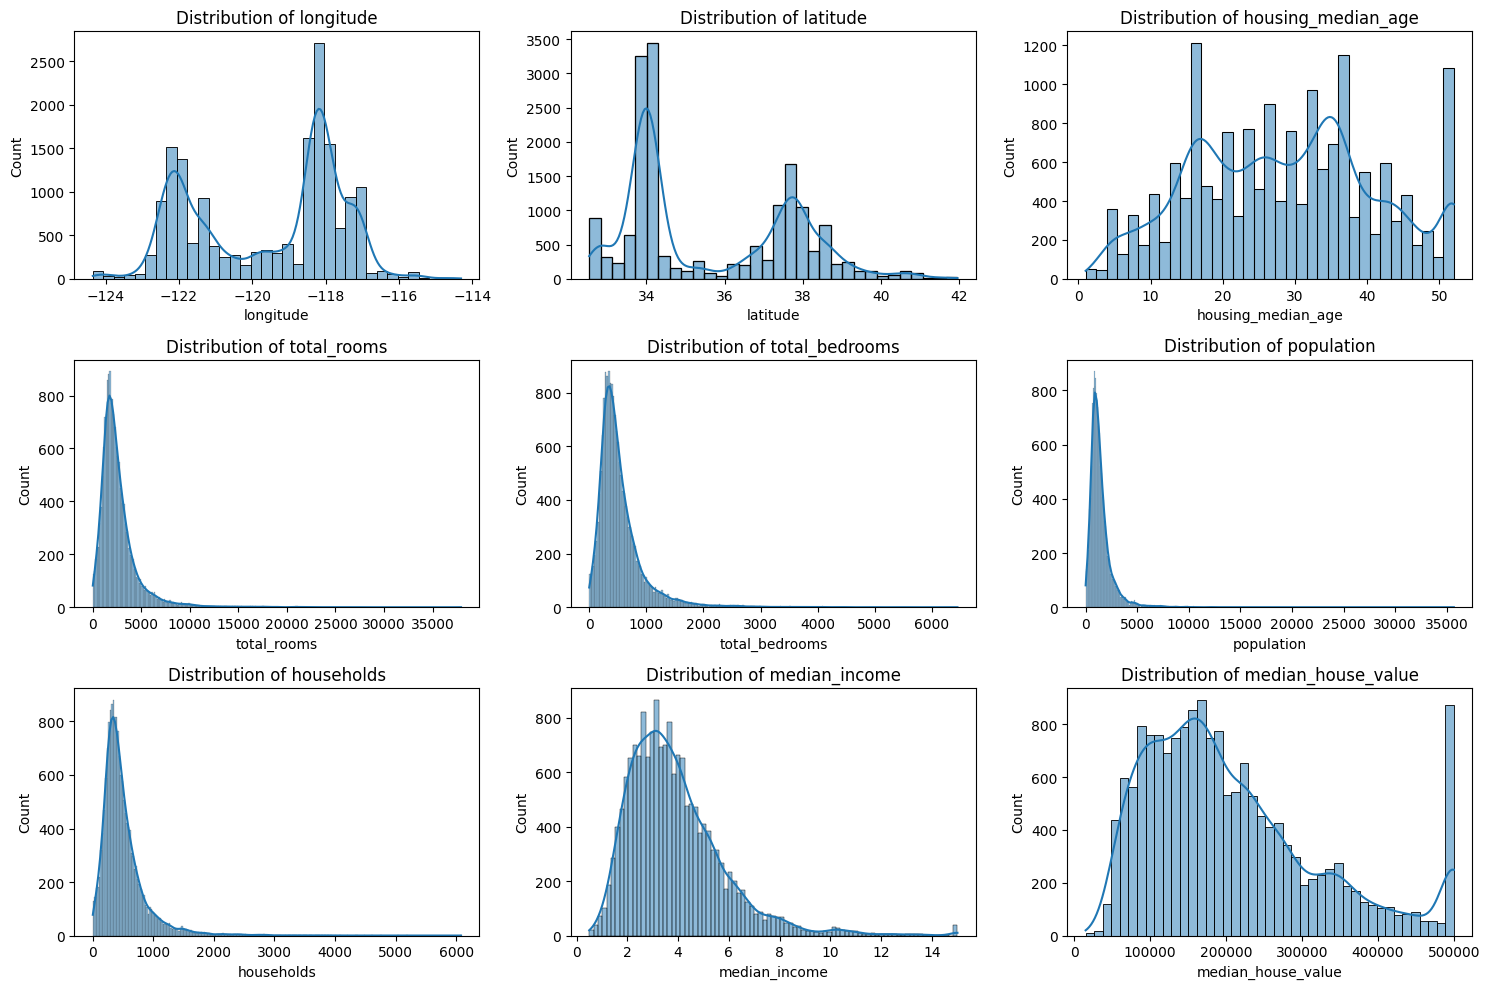

In [7]:
# 3.3 Distribution plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
plt.show()



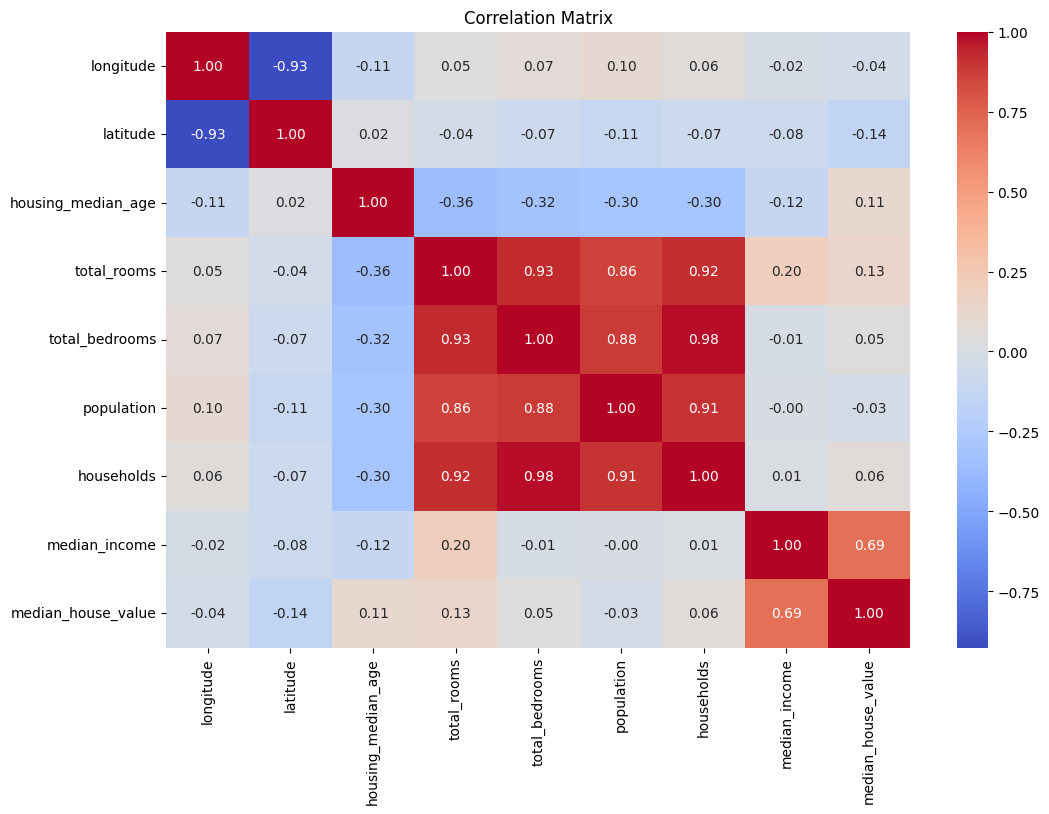

In [8]:
# 3.4 Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

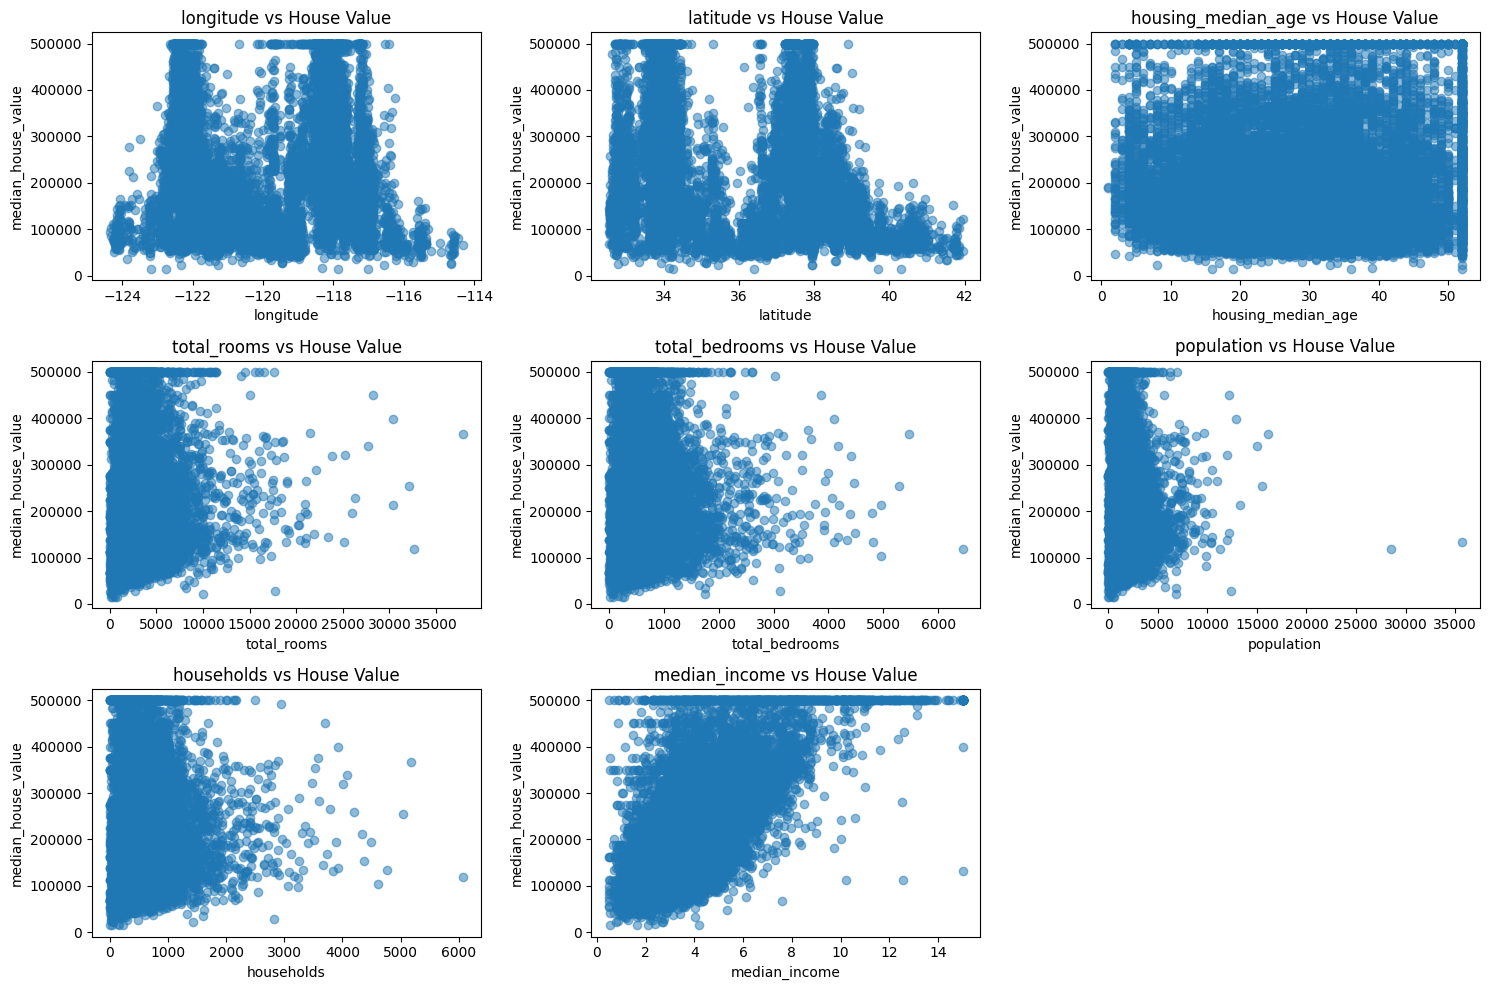

In [9]:
# 3.5 Scatter plots with target variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.drop('median_house_value', axis=1).columns, 1):
    plt.subplot(3, 3, i)
    plt.scatter(data[column], data['median_house_value'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('median_house_value')
    plt.title(f'{column} vs House Value')
plt.tight_layout()
plt.show()

In [10]:
# Step 4: Feature Engineering
def create_features(df):
    # Create copy of dataframe
    df = df.copy()
    
    # Basic ratio features
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    
    # Location based features
    df['distance_to_coast'] = np.sqrt((df['longitude'] + 124)**2 + 
                                    (df['latitude'] - 37)**2)
    
    # Income based features
    df['median_income_squared'] = df['median_income']**2
    
    # Log transforms for skewed features
    numeric_features = ['total_rooms', 'total_bedrooms', 'population', 
                       'households', 'median_income']
    
    for feature in numeric_features:
        df[f'log_{feature}'] = np.log1p(df[feature])
    
    # Binning location features
    df['latitude_bin'] = pd.qcut(df['latitude'], 10, labels=False)
    df['longitude_bin'] = pd.qcut(df['longitude'], 10, labels=False)
    
    return df

# Apply feature engineering
data_processed = create_features(data)

In [11]:
# Display new features
print("\nNew features created:")
display(data_processed.head())


New features created:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,...,population_per_household,distance_to_coast,median_income_squared,log_total_rooms,log_total_bedrooms,log_population,log_households,log_median_income,latitude_bin,longitude_bin
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0,11.889831,...,2.150424,10.089212,2.230841,8.632841,7.157735,6.923629,6.159095,0.913727,4,9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0,16.522678,...,2.438445,9.878305,3.312400,8.942592,7.550661,7.029973,6.139885,1.036737,5,9
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0,6.153846,...,2.846154,10.003484,2.725471,6.580639,5.164786,5.811141,4.770685,0.974899,1,9
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,6.641593,...,2.278761,10.010719,10.186949,7.314553,5.823046,6.246107,5.424950,1.433106,1,9
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0,5.549618,...,2.381679,10.034431,3.705625,7.282761,5.789960,6.437752,5.572154,1.073294,0,9


In [12]:
# Step 5: Feature Selection and Data Preprocessing
# 5.1 Separate features and target
X = data_processed.drop('median_house_value', axis=1)
y = data_processed['median_house_value']

In [13]:
# 5.2 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 5.3 Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [15]:
# Step 6: Model Training and Evaluation
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, 
                              cv=5, scoring='r2')
    
    print(f"\n{model_name} Results:")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"CV R2 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    return pipeline, y_pred

In [22]:
# 6.1 Train and evaluate Linear Regression
print("\n=== Linear Regression ===")
lr_model = LinearRegression()
lr_pipeline, lr_predictions = train_evaluate_model(
    lr_model, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    "Linear Regression"
)


=== Linear Regression ===

Linear Regression Results:
MAE: $46,342.70
RMSE: $63,719.19
R2 Score: 0.7053
CV R2 Score: 0.6339 (+/- 0.2144)


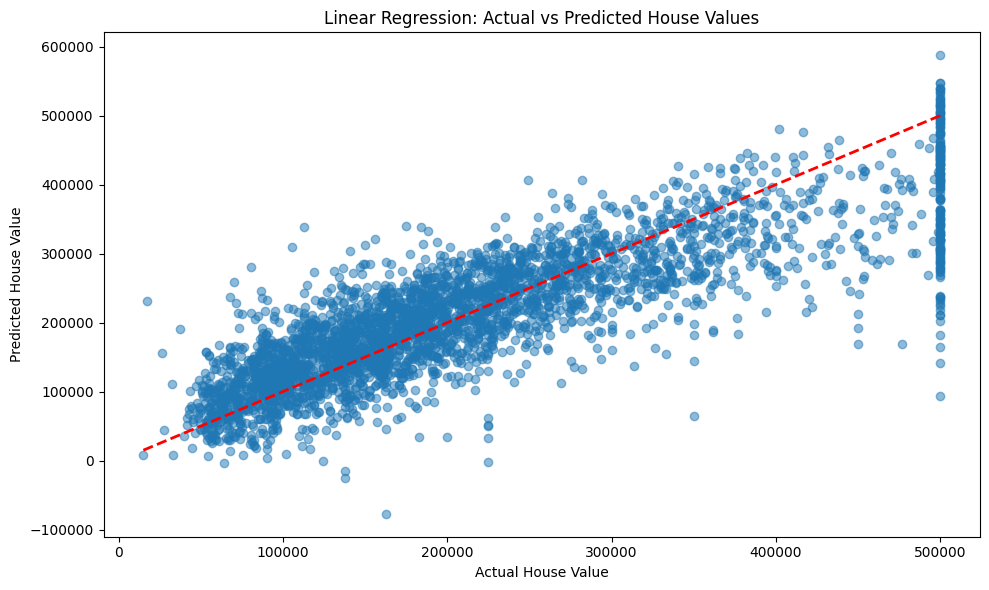

In [23]:
# Visualize Linear Regression predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Linear Regression: Actual vs Predicted House Values')
plt.tight_layout()
plt.show()

In [24]:
# 6.2 Train and evaluate Random Forest
print("\n=== Random Forest ===")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_pipeline, rf_predictions = train_evaluate_model(
    rf_model, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    "Random Forest"
)


=== Random Forest ===

Random Forest Results:
MAE: $35,379.42
RMSE: $52,466.43
R2 Score: 0.8002
CV R2 Score: 0.7913 (+/- 0.0310)


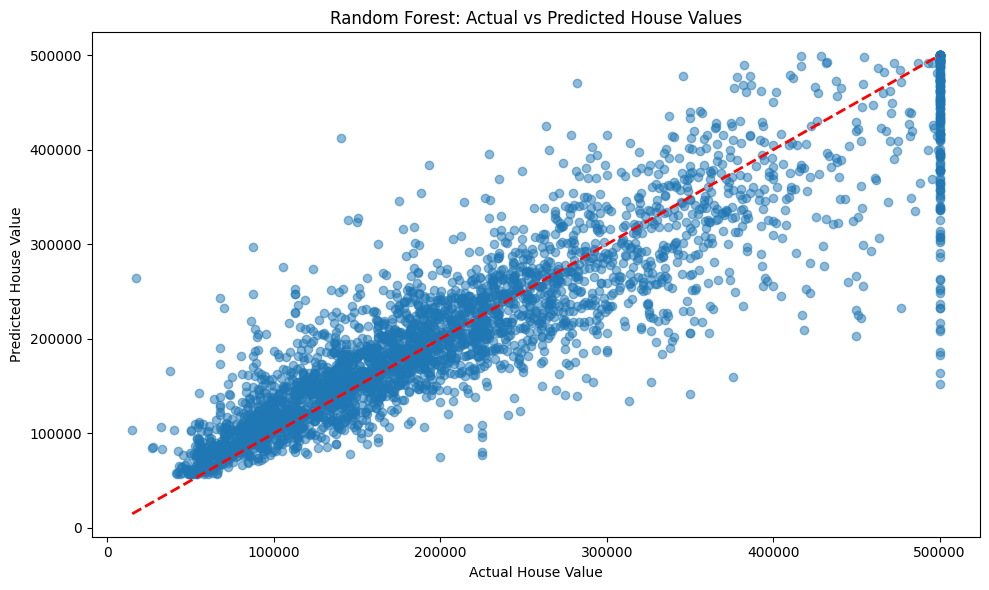

In [25]:
# Visualize Random Forest predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Random Forest: Actual vs Predicted House Values')
plt.tight_layout()
plt.show()


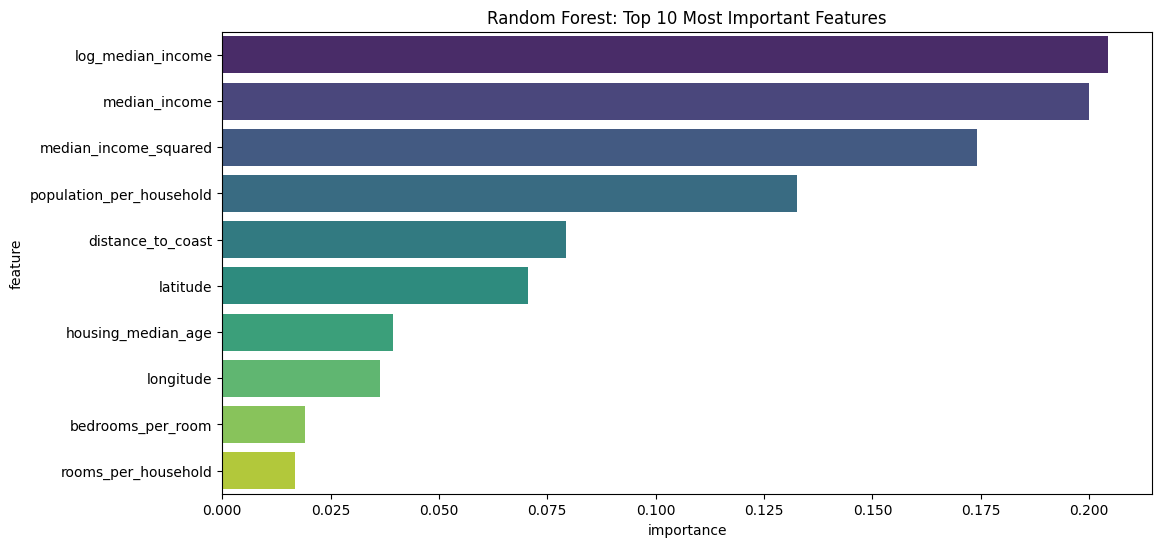

In [40]:
# Random Forest Feature Importance
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_pipeline.named_steps['regressor'].feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rf_feature_importance.head(10), palette='viridis')
plt.title('Random Forest: Top 10 Most Important Features')
plt.show()


In [27]:
# 6.3 Train and evaluate XGBoost
print("\n=== XGBoost ===")
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_pipeline, xgb_predictions = train_evaluate_model(
    xgb_model, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    "XGBoost"
)


=== XGBoost ===

XGBoost Results:
MAE: $31,906.62
RMSE: $47,772.01
R2 Score: 0.8344
CV R2 Score: 0.8275 (+/- 0.0240)


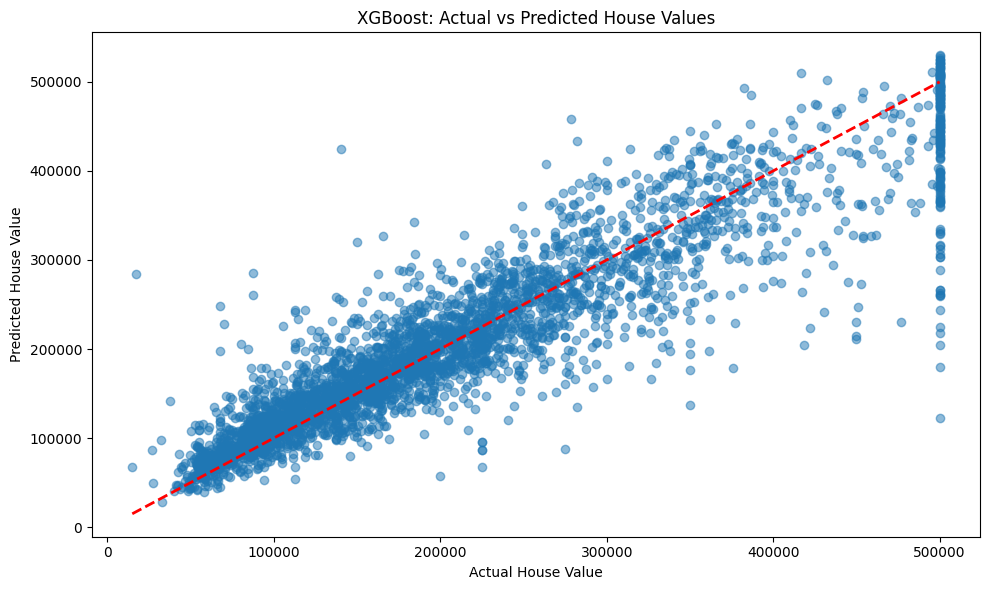

In [28]:
# Visualize XGBoost predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('XGBoost: Actual vs Predicted House Values')
plt.tight_layout()
plt.show()

In [29]:
# XGBoost Feature Importance
xgb_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_pipeline.named_steps['regressor'].feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values('importance', ascending=False)


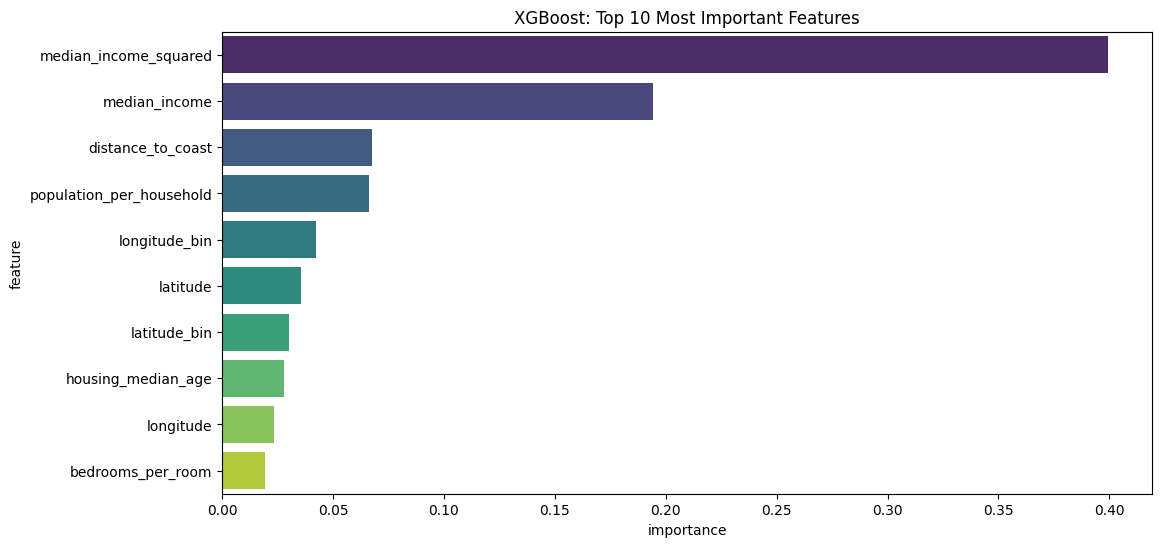

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=xgb_feature_importance.head(10), palette='viridis')
plt.title('XGBoost: Top 10 Most Important Features')
plt.show()

In [31]:
# 6.4 Train and evaluate Gradient Boosting
print("\n=== Gradient Boosting ===")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_pipeline, gb_predictions = train_evaluate_model(
    gb_model, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    "Gradient Boosting"
)


=== Gradient Boosting ===

Gradient Boosting Results:
MAE: $32,342.70
RMSE: $48,044.27
R2 Score: 0.8325
CV R2 Score: 0.8246 (+/- 0.0249)


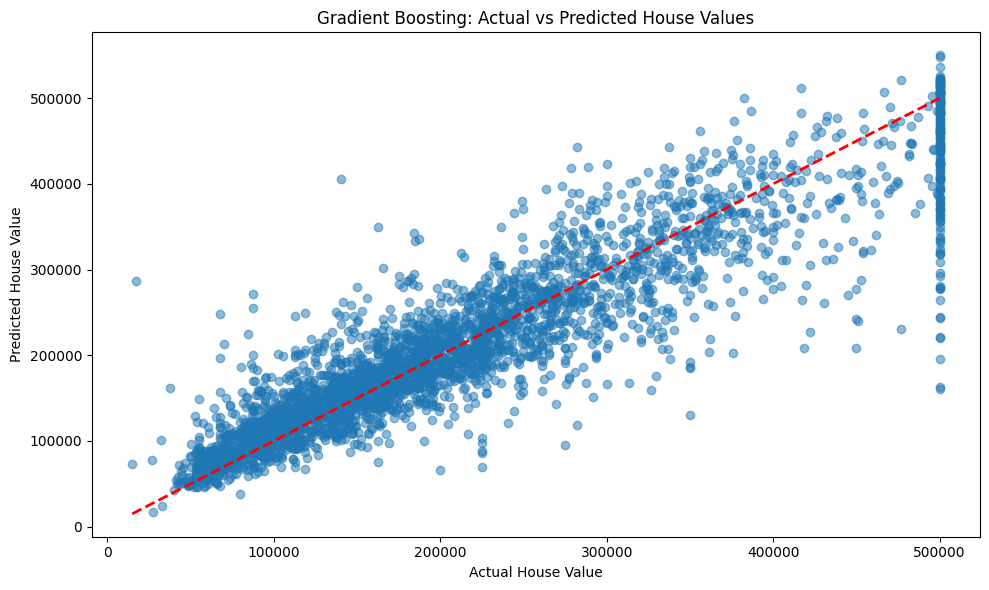

In [32]:
# Visualize Gradient Boosting predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Gradient Boosting: Actual vs Predicted House Values')
plt.tight_layout()
plt.show()

In [33]:
# Gradient Boosting Feature Importance
gb_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_pipeline.named_steps['regressor'].feature_importances_
})
gb_feature_importance = gb_feature_importance.sort_values('importance', ascending=False)


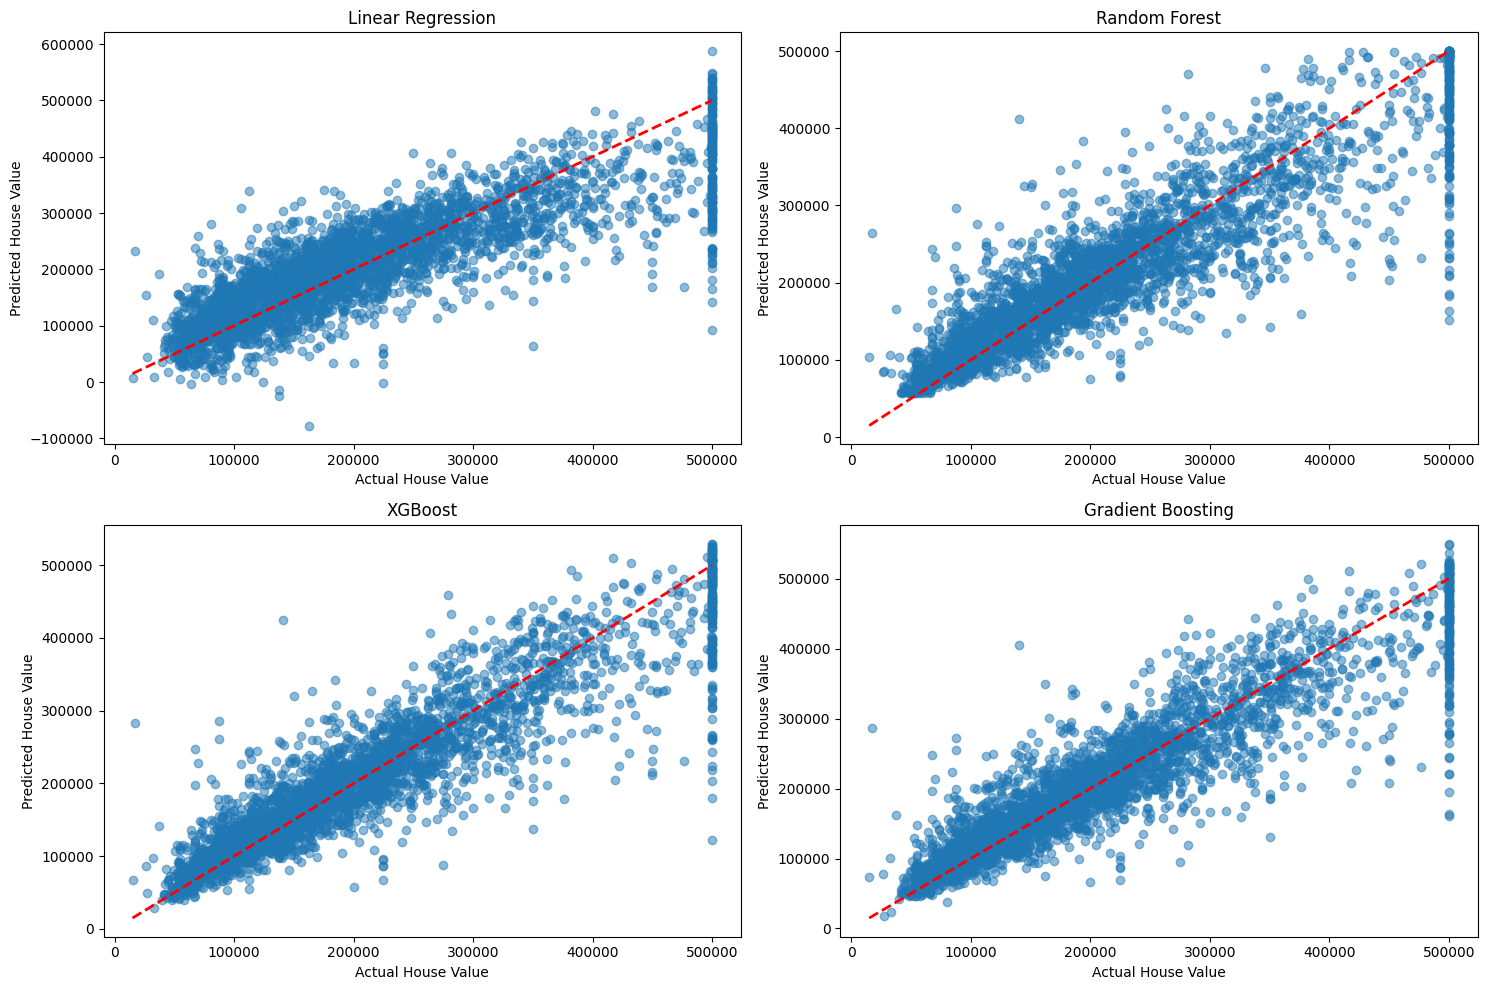

In [34]:
# Compare all models' predictions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_test, lr_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Linear Regression')

plt.subplot(2, 2, 2)
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Random Forest')

plt.subplot(2, 2, 3)
plt.scatter(y_test, xgb_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('XGBoost')

plt.subplot(2, 2, 4)
plt.scatter(y_test, gb_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Gradient Boosting')

plt.tight_layout()
plt.show()

Let's compare the results for each model based on the provided metrics:

1. **MAE (Mean Absolute Error):** Represents the average magnitude of errors in predictions. Lower MAE is better.
   
2. **RMSE (Root Mean Squared Error):** Measures error magnitude, with higher penalties for larger errors. Lower RMSE is preferable.

3. **R² (R-squared):** Indicates how well the model explains the variance in the target variable. Higher values (closer to 1) are better.

4. **CV R² Score (Cross-Validation R-squared):** Provides an estimate of how well the model generalizes to unseen data. The closer to 1, the better, and a smaller standard deviation indicates more stable results.

### Model Comparison Table:

| Metric                   | Linear Regression | Random Forest   | XGBoost         | Gradient Boosting |
|--------------------------|-------------------|-----------------|-----------------|-------------------|
| **MAE**                  | $46,342.70         | $35,379.42       | $31,906.62       | $32,342.70         |
| **RMSE**                 | $63,719.19         | $52,466.43       | $47,772.01       | $48,044.27         |
| **R² Score**             | 0.7053            | 0.8002          | 0.8344          | 0.8325            |
| **CV R² Score**          | 0.6339 (+/- 0.2144)| 0.7913 (+/- 0.0310) | 0.8275 (+/- 0.0240) | 0.8246 (+/- 0.0249) |

### Key Insights:

1. **MAE (Mean Absolute Error):**
   - **XGBoost** achieves the lowest MAE of **$31,906.62**, meaning it has the smallest average error in predicting the target variable.
   - **Random Forest** follows with **$35,379.42**, and **Gradient Boosting** is very close at **$32,342.70**.
   - **Linear Regression** has the highest MAE of **$46,342.70**, indicating larger errors compared to other models.

2. **RMSE (Root Mean Squared Error):**
   - **XGBoost** again leads with the lowest RMSE of **$47,772.01**, which means it has fewer large prediction errors than the others.
   - **Random Forest** follows with **$52,466.43**, while **Gradient Boosting** is slightly better at **$48,044.27**.
   - **Linear Regression** has the highest RMSE at **$63,719.19**, reflecting its poor handling of large errors.

3. **R² Score:**
   - **XGBoost** excels with the highest **R² score of 0.8344**, meaning it explains the greatest proportion of variance in the target variable.
   - **Gradient Boosting** and **Random Forest** are close behind with R² scores of **0.8325** and **0.8002**, respectively.
   - **Linear Regression** has the lowest R² score of **0.7053**, meaning it explains the least variance in the data.

4. **CV R² Score (Cross-Validation R-squared):**
   - **XGBoost** has the highest **CV R² score of 0.8275**, showing it generalizes well to unseen data with minimal variation (+/- 0.0240).
   - **Gradient Boosting** follows with **0.8246**, and **Random Forest** ranks third with **0.7913**.
   - **Linear Regression** has the lowest CV R² score of **0.6339** with a higher standard deviation (+/- 0.2144), indicating less consistent generalization across folds.

### Model Ranking (from best to worst):

1. **XGBoost** (Best overall performance across all metrics)
2. **Gradient Boosting** (Very close to XGBoost with strong generalization and performance)
3. **Random Forest** (Strong performer, especially in cross-validation)
4. **Linear Regression** (Least effective model with higher errors and lower R²)

### Conclusion:

- **XGBoost** stands out as the top performer, offering the lowest errors (MAE, RMSE), the highest R² score, and strong generalization (CV R²).
- **Gradient Boosting** is a close second, showing very similar performance to **XGBoost** but slightly lower R² and RMSE values.
- **Random Forest** is a strong choice as well, particularly for its excellent CV R² score and relatively low errors.
- **Linear Regression** is the least effective model, with the highest MAE and RMSE and the lowest R² scores, making it less suited for this problem compared to the other models.

### Recommendation:

If performance and generalization are the priorities, **XGBoost** should be your model of choice. It provides the best balance of prediction accuracy and stability. If interpretability or faster training times are important, **Random Forest** could be considered as a second option.

In [ ]:
# Save the best model (optional)
# import joblib
# joblib.dump(best_model, 'house_price_prediction_model.joblib')